In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Algorithm class

In [34]:
#%%writefile mergegram.py
import numpy as np
import networkx as nx
from networkx.algorithms import tree
from scipy.sparse.csgraph import minimum_spanning_tree

class Mergegram():
    def __init__(self, D):
        self.n = D.shape[0]
        G = nx.from_numpy_array(D)
        mst = tree.minimum_spanning_edges(G, algorithm="kruskal", data=True)
        self.edgelist = sorted([(e[0], e[1], e[2]['weight']) for e in list(mst)], 
                               key=lambda x: (x[2], x[0], [1]))
        self.UF = {(d,):0.0 for d in range(self.n)} #Union-Find with prev function images
        self.full = {(d,):0.0 for d in range(self.n)} #Union-Find without removing elements (for plotting) 
        self.output = []
        self._fit()
        
    def _fit(self):
        for e in self.edgelist:
            c1, c2 = self._find(e[0]), self._find(e[1])
            self.output.append((self.UF[c1], e[2]))
            self.output.append((self.UF[c2], e[2]))
            self.UF.pop(c1)
            self.UF.pop(c2)
            t = c1 + c2
            self.UF[t] = e[2]
            self.full[t] = e[2]
            
    def _find(self, c):
        try:
            return self.UF[c]
        except:
            for u in self.UF.keys():
                if type(u)==tuple and c in u:
                    return u
     
    def get_mergegram(self):
        return self.output

Writing mergegram.py


# Test 1 - simple distance matrix

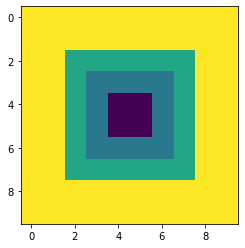

In [2]:
#test set 1 - simple adjacency matrix
A = np.zeros((10,10))

A[2:8,2:8] = 0.4
A[3:7,3:7] = 0.6
A[4:6,4:6] = 1.0

B = 1.0 - A
plt.imshow(B);


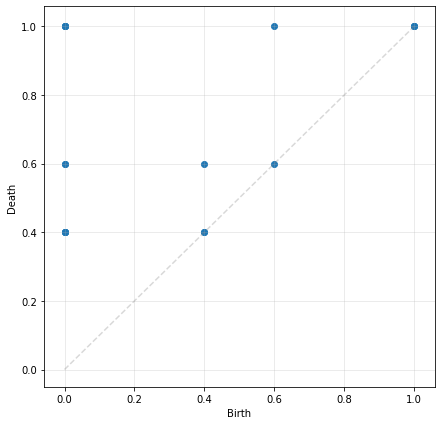

In [3]:
from mergegram import *

m = Mergegram(B)
mg = np.array(m.get_mergegram())

plt.figure(figsize=(7,7))
plt.scatter(mg[:,0], mg[:,1])
plt.plot([0,mg.max()],[0,mg.max()],alpha=0.3,ls='--',c='grey')
plt.xlabel('Birth')
plt.ylabel('Death')
plt.grid(alpha=0.3)

## clustering reconstruction

In [11]:
#here we find only first and last 0-homologies for each unique distance
history = m.full
unique = np.unique(list(history.values()))
total = [[(k, v) for k,v in history.items() if v==u] for u in unique]

transitions = []
for l in total[1:]:
    lens = [len(x[0]) for x in l]
    transitions.append([l[np.argmin(lens)], l[np.argmax(lens)]])

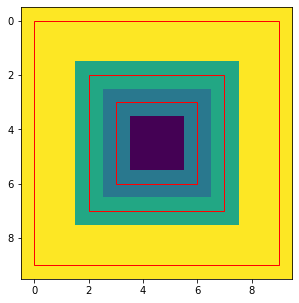

In [14]:
#and make the clustering
fig, ax = plt.subplots(1, figsize=(5,5))
ax.imshow(B)

for t in transitions:
    xy = t[1][0]
#     if len(xy) > 100 or len(xy) < 1:
#         continue

    x, y = min(xy), min(xy)
    d = max(xy) - min(xy)
    rect = patches.Rectangle((x, y), d, d,
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Test 2 - blobs

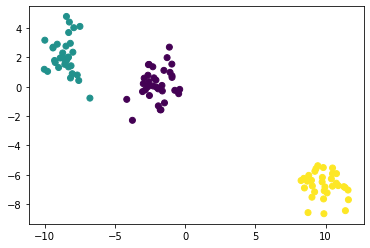

In [17]:
from scipy.spatial import distance_matrix
from sklearn.datasets import make_blobs

testD = make_blobs()
D = distance_matrix(testD[0], testD[0])
plt.scatter(testD[0][:,0], testD[0][:,1], c=testD[1])

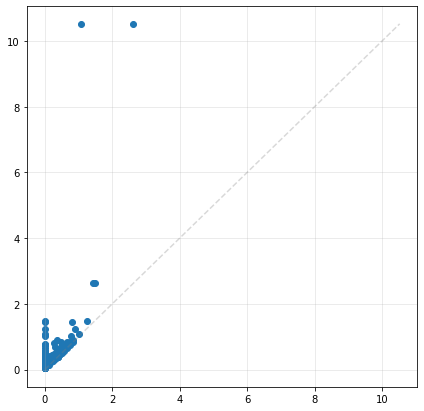

In [18]:
m = Mergegram(D)
mg = np.array(m.get_mergegram())

plt.figure(figsize=(7,7))
plt.scatter(mg[:,0], mg[:,1])
plt.plot([0,mg.max()],[0,mg.max()],alpha=0.3,ls='--',c='grey')
plt.grid(alpha=0.3)

# Hi-C data

The data is quite large for github, but you may try to download by yourself from [here](https://data.4dnucleome.org/files-processed/4DNFIZ1ZVXC8/).

In [26]:
import cooler
import pandas as pd

def mylog(mat, log=True):
    mat = np.where(np.isnan(mat) == True, 0, mat)
    matmin = mat.ravel()[np.nonzero(mat.ravel())].min()
    logmat = np.where(mat == 0, matmin / 2, mat)
    if log:
        logmat = np.log(logmat)
    return logmat

def extract_chrom_limits(cool):
    cool_df = pd.DataFrame(cool.bins()[:])
    chromdict = {}
    chromnames = cool.chromnames
    for chrom in chromnames:
        indexes = cool_df[cool_df['chrom'] == chrom].index
        start = indexes[0]
        end = indexes[-1]
        chromdict.update({chrom: (start, end + 1)})
    return chromdict

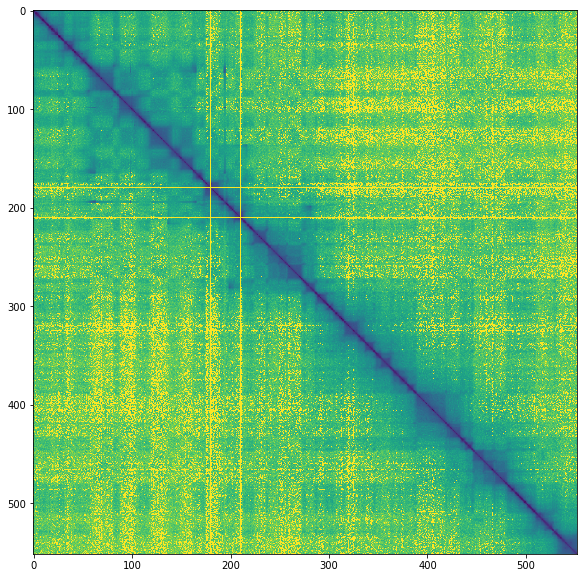

In [28]:
path2 = '../Bio/Data/hic/4DNFIZ1ZVXC8.mcool::/resolutions/10000'
cool = cooler.Cooler(path2)
chromdict = extract_chrom_limits(cool)
start = chromdict['chr2L'][0]
end = chromdict['chr2L'][1]

D = np.array(cool.matrix(balance=True, sparse=True)[start:end-1800, start:end-1800].toarray(), ndmin = 2)
D = mylog(D)

plt.figure(figsize=(10,10))
plt.imshow(np.abs(D));

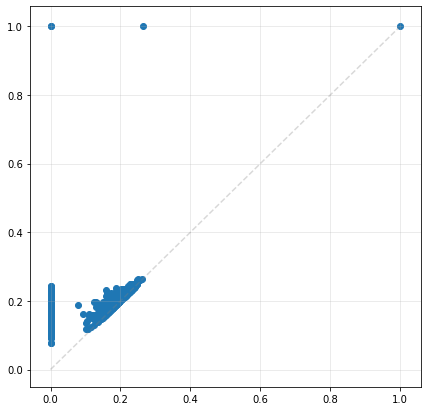

In [29]:
D = np.abs(D)
D = D/D.max()
bins = np.linspace(0,1,10000)
D = np.digitize(D, bins)
D = D/D.max()

m = Mergegram(D)
mg = np.array(m.get_mergegram())

plt.figure(figsize=(7,7))
plt.scatter(mg[:,0], mg[:,1])
plt.plot([0,mg.max()],[0,mg.max()],alpha=0.3,ls='--',c='grey')
plt.grid(alpha=0.3)

In [30]:
#here we find only first and last 0-homologies for each unique distance
history = m.full
unique = np.unique(list(history.values()))
total = [[(k, v) for k,v in history.items() if v==u] for u in unique]

transitions = []
for l in total[1:]:
    lens = [len(x[0]) for x in l]
    transitions.append([l[np.argmin(lens)], l[np.argmax(lens)]])

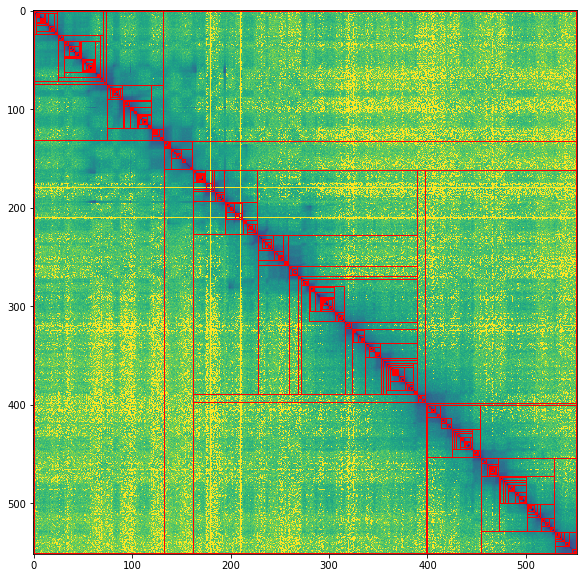

In [33]:
#and make the clustering
fig, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(D)

for t in transitions:
    xy = t[1][0]
#     if len(xy) > 100 or len(xy) < 1:
#         continue

    x, y = min(xy), min(xy)
    d = max(xy) - min(xy)
    rect = patches.Rectangle((x, y), d, d,
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

Not so good unfortunately(